In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import math
# importar future
from __future__ import print_function

c:\Users\Felipe de Jesus\miniconda3\envs\MLearn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class WeatherData(Dataset):
    def __init__(self,future=0):
        self.data = pd.read_csv('DataSQL/dfNL.csv')
        print (self.data.columns)
        #self.data = self.data.dropna()
        # rellenar los datos con promedios moviles o interpolaciones
        self.data = self.data.interpolate()
        self.data['Time'] = pd.to_datetime(self.data['Dia'])
        self.data = self.data.sort_values(by=['Sensor_id','Time'])
        self.data = self.data.set_index('Time')
        self.Municipios = self.data['Sensor_id'].unique()
        self.Mundicc = {}
        self.data.fillna(0, inplace=True)
        # hacer un diccionario para el nombre de los municipios
        for i in range(len(self.Municipios)):
            self.Mundicc[self.Municipios[i]] = i
        # Aplicar el diccionario al dataframe
        #self.data['Sensor_id'] = self.data['Sensor_id'].map(self.Mundicc)
        #for col in self.data.columns:
        #    self.data = self.data[self.data[col]>=0]
        # numpy array
        # agarrar solo datos de la estacion 0
        self.data = self.data[self.data['Sensor_id'] == 'ANL11']
        print (self.data.head(n=1))
        # quitar columna estacíon
        self.data = self.data.drop(columns=['Sensor_id'])
        self.columns = self.data.columns
        # standarizar los datos
        self.mean = self.data.mean()
        self.std = self.data.std()
        self.data = (self.data - self.mean)/self.std
        # correjir los NaN
        self.data = self.data.fillna(0)
        # borrar las columnas ['Unnamed: 0', 'Dia', 'Hora']
        self.data = self.data.drop(columns=['Unnamed: 0','Registros_id','Dia'])
        self.columns = self.data.columns
        self.data = self.data.to_numpy()
        # convertir los numeros menores a 0 en 
        self.x = torch.tensor(self.data[:-1], dtype=torch.float)
        self.y = torch.tensor(self.data[1:], dtype=torch.float)
        self.set_future(future)
        
    def set_future(self, future):
        self.future = future
    def __len__(self):
        return len(self.data)-self.future-1

    def __getitem__(self, idx):
        return self.x[idx].unsqueeze(0),self.y[idx].unsqueeze(0)
    def get_batch(self, batch_size, future = 0):
        idx = np.random.randint(0, len(self.data)-future-1, batch_size)
        return self.x[idx],self.y[idx+future]

In [3]:
def LinearCell(num_input, num_hidden, Dropout=0.1):
    Seq = nn.Sequential(
        nn.Linear(num_input,num_hidden),
        nn.LeakyReLU(0.8),
        nn.Dropout(Dropout)
    )
    return Seq

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [5]:

class Net(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers, num_linear =1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers)
        LinearSeq = []
        for i in range(num_linear):
            LinearSeq.append(LinearCell(hidden_size,hidden_size,Dropout=0))
        self.LinearSeq = nn.Sequential(*LinearSeq)
        self.L1 = LinearCell(hidden_size,hidden_size,Dropout=0)
        self.L2 = LinearCell(hidden_size,hidden_size,Dropout=0)
        self.LOut = LinearCell(hidden_size,output_size,Dropout=0)
        self.init_weights()
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.normal_(m.bias)
    def forward(self,x,future=0):
        # outputs
        outputs = []
        h_t = torch.zeros(self.num_layers,1,self.hidden_size)
        c_t = torch.zeros(self.num_layers,1,self.hidden_size)
        
        for input_t in x.split(1,dim=0):
            out, (h_t,c_t) = self.lstm1(input_t,(h_t,c_t))
            #print (out.shape)
            out = self.LinearSeq(out)
            l1 = self.L1(out)
            l2 = self.L2(l1)
            output = self.LOut(l2)
            outputs.append(output)
        
        for i in range(future):
            out, (h_t,c_t) = self.lstm1(output, (h_t,c_t))
            out = self.LinearSeq(out)
            l1 = self.L1 (out)
            l2 = self.L2(l1)
            output = self.LOut(l2)
            outputs.append(output)
        outputs = torch.cat(outputs,dim=0)
        return outputs

In [6]:
# pararmetros del entrenamiento
learning_rate = .001
num_epochs = 1000
batch_size = 240
clip = .5
future = 100
Prediction_weight = 1.2
dataset = WeatherData()
Batch_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

Index(['Unnamed: 0', 'Registros_id', 'Dia', 'PM10', 'PM25', 'O3', 'CO', 'NO1',
       'NO2', 'NOx', 'SO2', 'Sensor_id', 'TEMPERATURA', 'LLUVIA', 'PRESIONATM',
       'HUMEDAD', 'RS', 'VIENTOVEL'],
      dtype='object')
                     Unnamed: 0  Registros_id                  Dia  PM10  \
Time                                                                       
2018-01-01 08:00:00      420784       1887900  2018-01-01 08:00:00   8.0   

                           PM25     O3    CO  NO1       NO2  NOx     SO2  \
Time                                                                       
2018-01-01 08:00:00  294.950469  0.013  0.06  0.0  0.011818  0.0  0.0033   

                    Sensor_id  TEMPERATURA  LLUVIA  PRESIONATM  HUMEDAD   RS  \
Time                                                                           
2018-01-01 08:00:00     ANL11          0.0     0.0         0.0      0.0  0.0   

                     VIENTOVEL  
Time                            
2018-01-01 08:00

C:\Users\Felipe de Jesus\AppData\Local\Temp\ipykernel_9704\3273339882.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.mean = self.data.mean()
C:\Users\Felipe de Jesus\AppData\Local\Temp\ipykernel_9704\3273339882.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.std = self.data.std()


In [7]:
input_size = dataset.columns.__len__()
print (input_size)
max_lenght = 48
argument = {
    'input_size' : input_size,
    'hidden_size' : 18,
    'output_size' : input_size,
    'num_layers' : 3,
    'num_linear' : 2
}
Predictor = Net(**argument)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Predictor.parameters(), lr=learning_rate)

14


In [9]:
# cargar los pesos
Predictor.load_state_dict(torch.load('Model/Checkpoint.pt'))

<All keys matched successfully>

In [58]:
sample_t = torch.zeros(1,1,input_size)
output = Predictor(sample_t)
print (output.shape)

torch.Size([1, 1, 17])


In [10]:
from tqdm  import tqdm
import matplotlib.pyplot as plt

def test(Predictor,test_data,size,future=60,it = 0):
    iterat = DataLoader(test_data, batch_size=size, shuffle=False)
    iterat = iter(iterat)
    for i in range(it):
        (x,y) = next(iterat)
        print (x.shape)
    out = Predictor(x[:-future],future=future)
    Y_proyectado = out.detach().numpy()[:,0,7]
    Y_real = y.detach().numpy()[:,0,7]
    plt.plot(Y_real,label='Real')
    plt.plot(Y_proyectado,label='Prediccion')
    plt.axvline(x=size-future, color='black', linestyle='--')
    plt.legend()
    plt.show()

In [11]:
#min_loss = 0.24296
#min_loss = 0.19
min_loss = math.inf

In [12]:
# load checkpoint
Predictor.load_state_dict(torch.load('Model/Ideal.pt'))

<All keys matched successfully>

Epoch: 0 Loss: 55.57886:   0%|          | 0/1000 [01:23<?, ?it/s]

torch.Size([200, 1, 14])


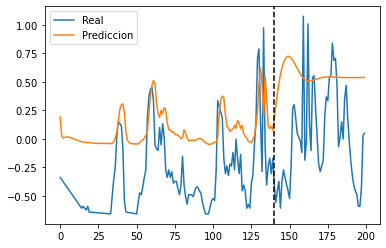

Epoch: 5 Loss: 55.33275:   0%|          | 5/1000 [08:20<22:59:54, 83.21s/it]

torch.Size([200, 1, 14])


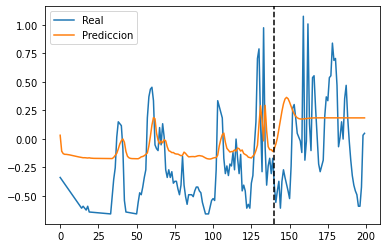

Epoch: 10 Loss: 46.85095:   1%|          | 10/1000 [14:28<19:22:18, 70.44s/it]

torch.Size([200, 1, 14])


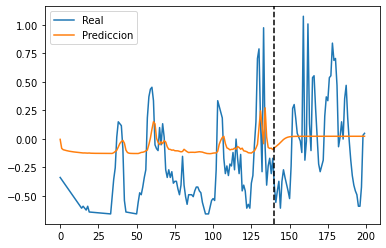

Epoch: 15 Loss: 42.86415:   2%|▏         | 15/1000 [21:19<21:58:17, 80.30s/it]

torch.Size([200, 1, 14])


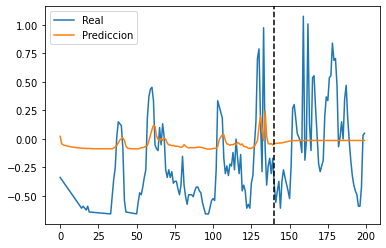

Epoch: 20 Loss: 42.69973:   2%|▏         | 20/1000 [28:16<22:35:39, 83.00s/it]

torch.Size([200, 1, 14])


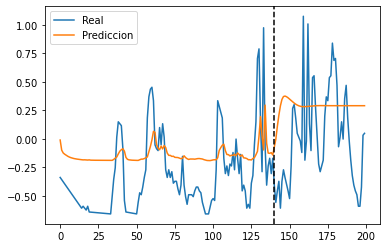

Epoch: 25 Loss: 42.69863:   2%|▎         | 25/1000 [35:15<22:44:03, 83.94s/it]

torch.Size([200, 1, 14])


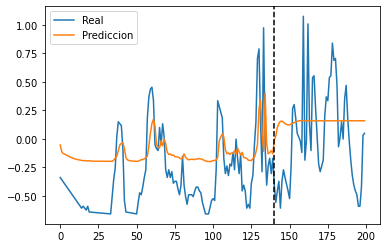

Epoch: 30 Loss: 42.35460:   3%|▎         | 30/1000 [42:08<22:18:11, 82.77s/it]

torch.Size([200, 1, 14])


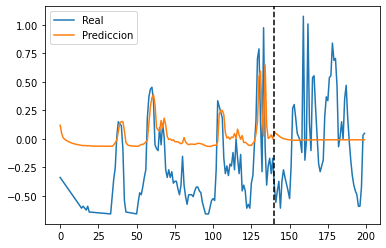

Epoch: 35 Loss: 43.78483:   4%|▎         | 35/1000 [49:05<22:17:22, 83.15s/it]

torch.Size([200, 1, 14])


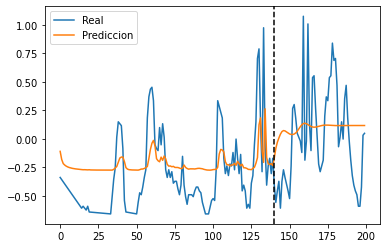

Epoch: 40 Loss: 42.88914:   4%|▍         | 40/1000 [55:59<22:09:26, 83.09s/it]

torch.Size([200, 1, 14])


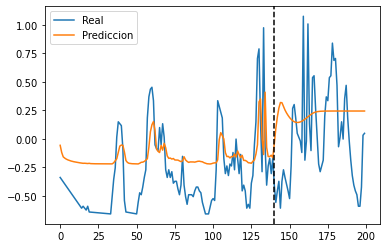

Epoch: 45 Loss: 44.01349:   4%|▍         | 45/1000 [1:03:06<22:15:19, 83.90s/it]

torch.Size([200, 1, 14])


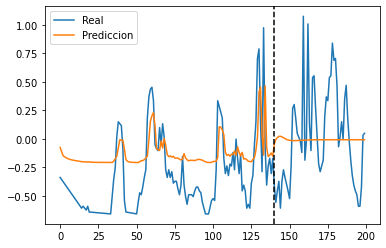

Epoch: 50 Loss: 42.06240:   5%|▌         | 50/1000 [1:10:05<22:10:30, 84.03s/it]

torch.Size([200, 1, 14])


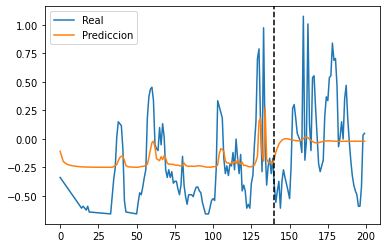

Epoch: 55 Loss: 42.25290:   6%|▌         | 55/1000 [1:17:11<22:11:43, 84.55s/it]

torch.Size([200, 1, 14])


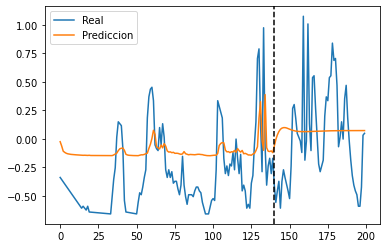

Epoch: 60 Loss: 42.91645:   6%|▌         | 60/1000 [1:24:10<21:53:13, 83.82s/it]

torch.Size([200, 1, 14])


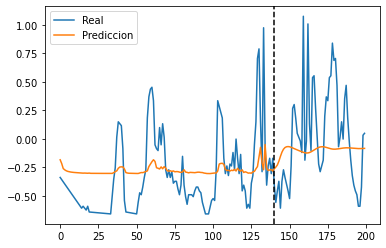

Epoch: 65 Loss: 42.27487:   6%|▋         | 65/1000 [1:31:18<22:03:19, 84.92s/it]

torch.Size([200, 1, 14])


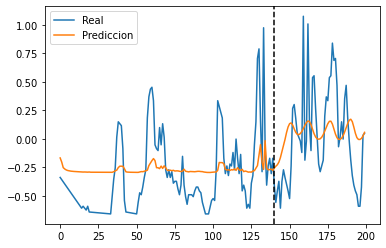

Epoch: 70 Loss: 42.04176:   7%|▋         | 70/1000 [1:38:17<21:37:32, 83.71s/it]

torch.Size([200, 1, 14])


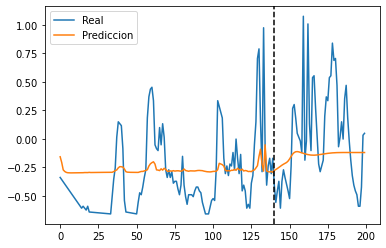

Epoch: 75 Loss: 41.84543:   8%|▊         | 75/1000 [1:45:12<21:18:53, 82.96s/it]

torch.Size([200, 1, 14])


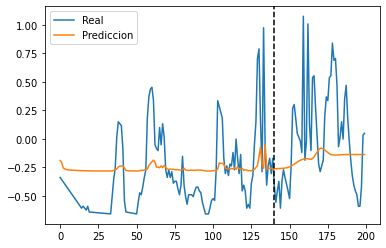

Epoch: 80 Loss: 41.89394:   8%|▊         | 80/1000 [1:52:11<21:21:05, 83.55s/it]

torch.Size([200, 1, 14])


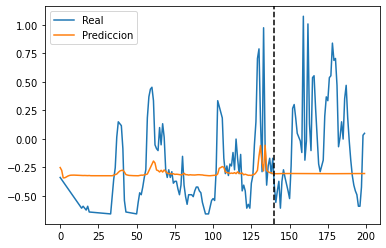

Epoch: 85 Loss: 41.71845:   8%|▊         | 85/1000 [1:59:05<21:05:12, 82.96s/it]

torch.Size([200, 1, 14])


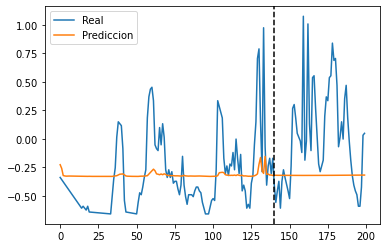

Epoch: 90 Loss: 41.40947:   9%|▉         | 90/1000 [2:05:59<20:56:54, 82.87s/it]

torch.Size([200, 1, 14])


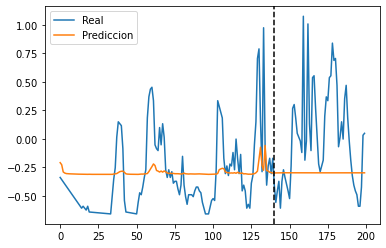

Epoch: 95 Loss: 41.67252:  10%|▉         | 95/1000 [2:12:52<20:45:56, 82.60s/it]

torch.Size([200, 1, 14])


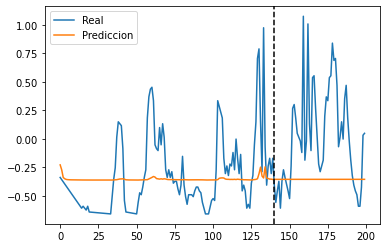

Epoch: 100 Loss: 41.13216:  10%|█         | 100/1000 [2:19:52<20:55:12, 83.68s/it]

torch.Size([200, 1, 14])


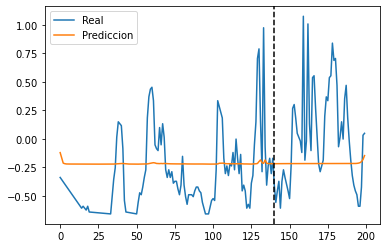

Epoch: 105 Loss: 41.27527:  10%|█         | 105/1000 [2:26:50<20:48:12, 83.68s/it]

torch.Size([200, 1, 14])


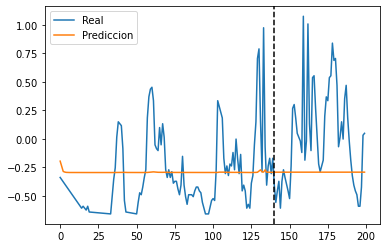

Epoch: 110 Loss: 41.07067:  11%|█         | 110/1000 [2:33:52<20:46:38, 84.04s/it]

torch.Size([200, 1, 14])


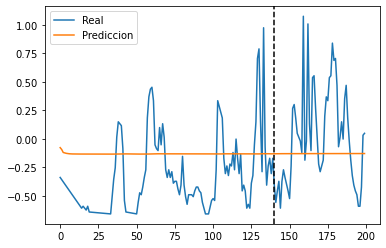

Epoch: 115 Loss: 41.22933:  12%|█▏        | 115/1000 [2:40:48<20:30:45, 83.44s/it]

torch.Size([200, 1, 14])


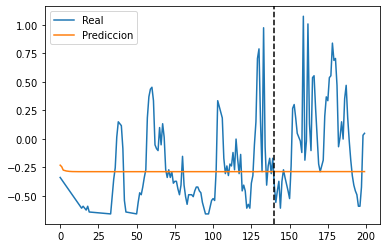

Epoch: 120 Loss: 41.45051:  12%|█▏        | 120/1000 [2:47:53<20:34:02, 84.14s/it]

torch.Size([200, 1, 14])


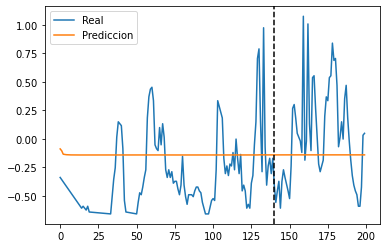

Epoch: 125 Loss: 41.20797:  12%|█▎        | 125/1000 [2:54:50<20:18:12, 83.53s/it]

torch.Size([200, 1, 14])


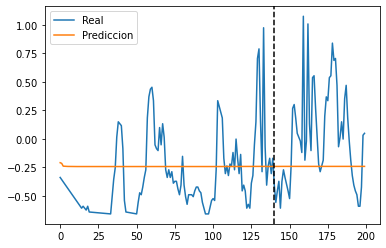

Epoch: 130 Loss: 41.47349:  13%|█▎        | 130/1000 [3:02:02<20:34:11, 85.12s/it]

torch.Size([200, 1, 14])


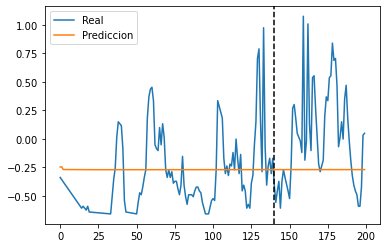

Epoch: 135 Loss: 41.02640:  14%|█▎        | 135/1000 [3:09:09<20:23:29, 84.87s/it]

torch.Size([200, 1, 14])


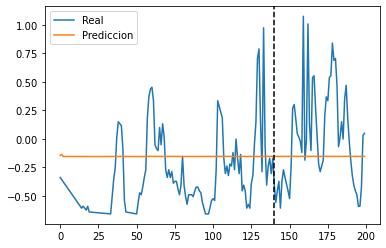

Epoch: 140 Loss: 41.49694:  14%|█▍        | 140/1000 [3:16:11<20:10:06, 84.43s/it]

torch.Size([200, 1, 14])


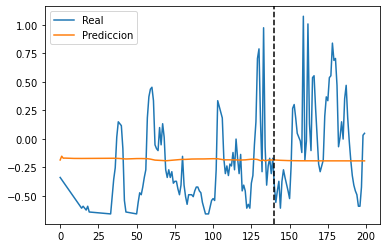

Epoch: 145 Loss: 40.79886:  14%|█▍        | 145/1000 [3:23:19<20:10:07, 84.92s/it]

torch.Size([200, 1, 14])


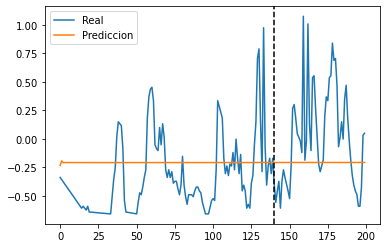

Epoch: 150 Loss: 41.18953:  15%|█▌        | 150/1000 [3:30:21<19:57:12, 84.51s/it]

torch.Size([200, 1, 14])


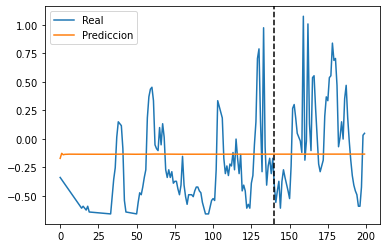

Epoch: 155 Loss: 40.52289:  16%|█▌        | 155/1000 [3:37:21<19:36:31, 83.54s/it]

torch.Size([200, 1, 14])


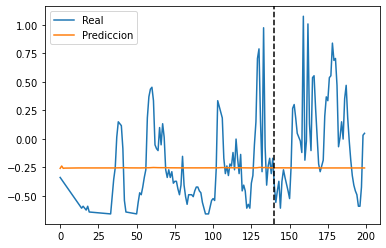

Epoch: 160 Loss: 40.39942:  16%|█▌        | 160/1000 [3:44:20<19:33:02, 83.79s/it]

torch.Size([200, 1, 14])


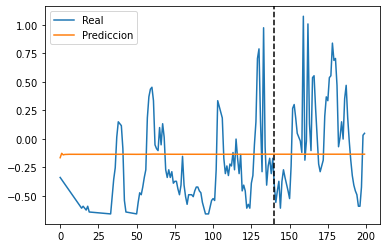

Epoch: 165 Loss: 40.35723:  16%|█▋        | 165/1000 [3:51:19<19:32:27, 84.25s/it]

torch.Size([200, 1, 14])


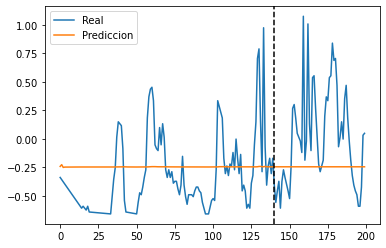

Epoch: 170 Loss: 40.46361:  17%|█▋        | 170/1000 [3:58:19<19:20:59, 83.93s/it]

torch.Size([200, 1, 14])


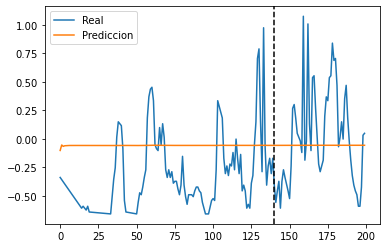

Epoch: 175 Loss: 42.28241:  18%|█▊        | 175/1000 [4:05:15<19:08:51, 83.55s/it]

torch.Size([200, 1, 14])


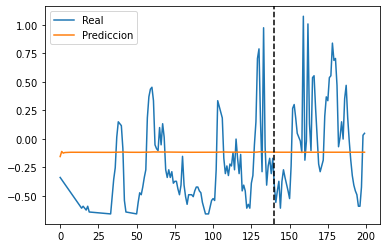

Epoch: 180 Loss: 40.24875:  18%|█▊        | 180/1000 [4:12:12<18:57:13, 83.21s/it]

torch.Size([200, 1, 14])


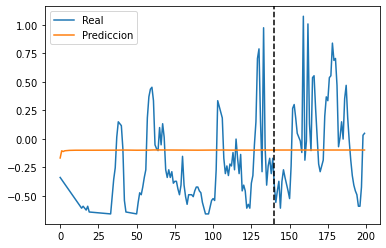

Epoch: 185 Loss: 40.50848:  18%|█▊        | 185/1000 [4:19:11<18:49:26, 83.15s/it]

torch.Size([200, 1, 14])


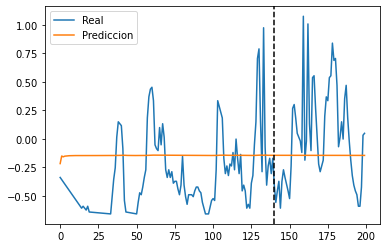

Epoch: 190 Loss: 40.56929:  19%|█▉        | 190/1000 [4:26:07<18:43:32, 83.23s/it]

torch.Size([200, 1, 14])


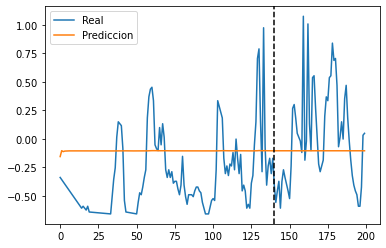

Epoch: 191 Loss: 40.20957:  19%|█▉        | 192/1000 [4:27:29<18:45:39, 83.59s/it]


KeyboardInterrupt: 

In [12]:
progress = tqdm(range(num_epochs))
outputs = torch.zeros(1,max_lenght,input_size)
for epoch in progress:
    mean_loss = 0.0
    for _,(x,y) in enumerate(Batch_loader):
        if x.shape[0] < batch_size:
            continue
        out = Predictor(x[:-future],future=future)
        teached_out = out[:-future]
        predicted_out = out[-future:]
        teached_loss = criterion(teached_out,y[:-future])
        predicted_loss = criterion(predicted_out,y[-future:])
        loss = ((teached_loss*0.4) + (predicted_loss * 0.6)) / 2
        if torch.cuda.is_available():
            loss = loss.cuda()
        mean_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(Predictor.parameters(), clip)
        optimizer.step()
    #mean_loss += loss
    #mean_loss = mean_loss / len(Batch_loader)
    #optimizer.zero_grad()
    #mean_loss.backward()
    #torch.nn.utils.clip_grad_norm_(Predictor.parameters(), clip)
    #optimizer.step()
    progress.set_description("Epoch: {} Loss: {:.5f}".format(epoch,mean_loss))
    if mean_loss < min_loss and mean_loss> 0:
        min_loss = mean_loss
        # save checkpoint
        torch.save(Predictor.state_dict(), 'Model/Checkpoint.pt')

    if epoch % 5 == 0:
        test(Predictor,dataset,200,future=60,it=1)

In [79]:
print ('Minimo Loss: ',min_loss)

Minimo Loss:  0.23191717267036438


In [22]:
# guardar el modelo
torch.save(Predictor.state_dict(), 'Model/Ideal.pt')

torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])


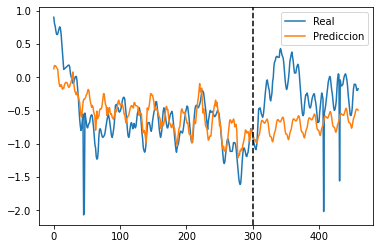

In [32]:
context = 300 
pred = 160
test(Predictor,dataset,context+pred,future=pred,it=7)

In [14]:
# make a function to predict same as test, but generate 100 generations and print the mean and std
def predict(Predictor,test_data,size,future=60,it = 0, gens = 100):
    iterat = DataLoader(test_data, batch_size=size, shuffle=False)
    iterat = iter(iterat)
    for i in range(it):
        (x,y) = next(iterat)
    outputs = []
    for i in range(gens):
        out = Predictor(x[:-future],future=future)
        Y_proyectado = out.detach().numpy()[:,0,0]
        outputs.append(Y_proyectado)
        Y_real = y.detach().numpy()[:,0,0]
    outputs = np.array(outputs)
    mean = outputs.mean(axis=0)
    std = outputs.std(axis=0)
    # dont print the results of the prediction before the axvline
    plt.plot(Y_real,label='Real')
    plt.plot(mean,label='Prediccion')
    plt.fill_between(np.arange(mean.shape[0]),mean-std,mean+std,alpha=0.5)
    plt.axvline(x=size-future, color='black', linestyle='--')
    plt.legend()
    plt.show()

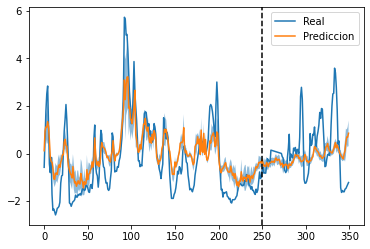

In [32]:
predict(Predictor,dataset,350,future=100,it=1,gens=10)